<a href="https://colab.research.google.com/github/raigit/ML_GNN_PRACTICE/blob/master/MaximeLabonne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
'''
Every codes and texts comes form Maxime Labonne's github
https://mlabonne.github.io/blog/intrognn/#%E2%9C%89%EF%B8%8F-II.-Graph-Convolutional-Network
'''

In [ ]:
# Graph Convolutional Netwroks : Introduction to GNNs

In [ ]:
# 1. Graph data

In [1]:
import torch
! pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
! pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
! pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

import numpy as np

import matplotlib.pyplot as plt
import networkx as nx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 13.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 KB 6.0 MB/s eta 0:00:00


In [47]:
# node classification using Zachary's karate club

from torch_geometric.datasets import KarateClub
dataset = KarateClub()

In [48]:
print(dataset)
print('*****')
print(f'Number of graphs : {len(dataset)}')
print(f'Number of features : {dataset.num_features}')
print(f'Number of classes : {dataset.num_classes}')
# Each node has a feature vector of 34 dimensions and is part of one out of four classes

KarateClub()
*****
Number of graphs : 1
Number of features : 34
Number of classes : 4


In [49]:
print(f'Graph : {dataset[0]}')
# Dataset object can be seen as a collection of Data(graph) object
# x = [34, 34] : node feature matrix with shape (number of nodes, number of features)
# in this example, we have 34 nodes and each node being associated to a 34-dim feature vector
# edge_index = [2, 156] : graph connectivity (how the nodes are connected) with shape
# y = [34] is the node ground-truth labels
# train_mask = [34] is an optional attribute that tells which nodes should be used for training with a list of True or False

Graph : Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


In [50]:
data = dataset[0]
print(f'x = {data.x.shape}')
print(data.x)

x = torch.Size([34, 34])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])


In [51]:
print(f'edge_index = {data.edge_index}')
print(data.edge_index)
# edge_index has a quite counter-intuitive way os storing the graph connectivity
# we have two lists of 156 directed edges (78 bidirectional edges)
# first list contains the sources and the second one the destinations
# It is called a coordinate list(COO) and is just one way of efficiently storing a sparse matrix

edge_index = tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3,  0,  2, 30, 32, 33,  

In [52]:
# A more intuitive way to represent the graph connectivity would be a simple adjacency matrix A
# The adjacency matrix can be inferred from the edge_index with a utility function

from torch_geometric.utils import to_dense_adj

A = to_dense_adj(data.edge_index)[0].numpy().astype('int')
print(A)
print(f'A = {A.shape}')
# WIth graph data, nodes are rarely highly interconnected
# adjacency matrix A is very sparse

[[0 1 1 ... 1 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 1 0]
 ...
 [1 0 0 ... 0 1 1]
 [0 0 1 ... 1 0 1]
 [0 0 0 ... 1 1 0]]
A = (34, 34)


In [53]:
print(f'y = {data.y.shape}')
print(data.y)
# ground-truth labels stored in y
# simply encode the group number (0, 1, 2, 3) for each node, which is why have 34 values

y = torch.Size([34])
tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])


In [54]:
print(f'train_mask : {data.train_mask.shape}')
print(data.train_mask)
# train mask shows which nodes are supposed to be used for training with True statements

train_mask : torch.Size([34])
tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])


In [55]:
# Data object has a lot more information
# is_directed() tells you if the graph is directed, which means that the adjacency matrix is not symmetric
print(f'Edges are directed : {data.is_directed()}')
# has_isolated_nodes() checks is some nodes are not connected to the rest of the graph
print(f'Graph has isolated nodes : {data.has_isolated_nodes()}')
# has_self_loops() indicates if at least one node is connected to itself
print(f'Graph has loops : {data.has_self_loops()}')

Edges are directed : False
Graph has isolated nodes : False
Graph has loops : False


In [56]:
data.y

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])

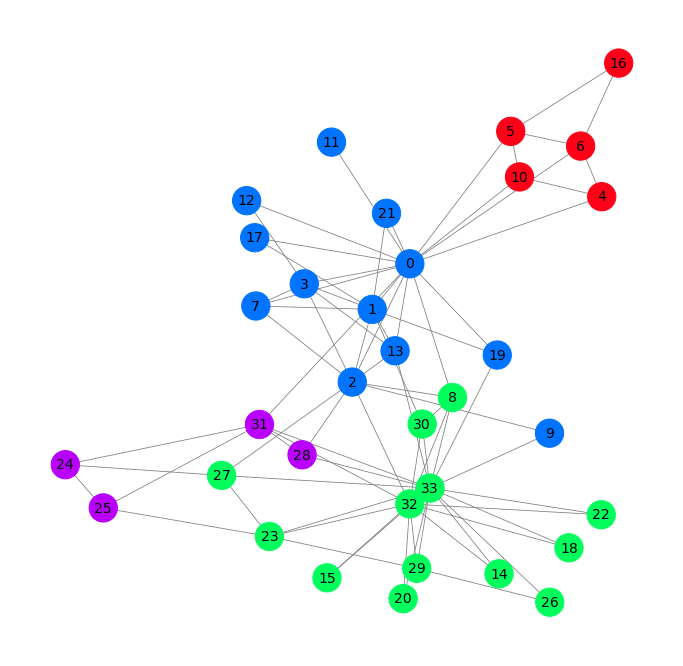

In [57]:
# We can plot out dataset with using NetworkX
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected = True)
plt.figure(figsize = (12, 12))
plt.axis('off')
nx.draw_networkx(G,
                 pos = nx.spring_layout(G, seed = 0),
                 with_labels = True,
                 node_size = 800,
                 node_color = data.y,
                 cmap = 'hsv',
                 vmin = -2,
                 vmax = 3,
                 width = 0.8,
                 edge_color = 'grey',
                 font_size = 14)
plt.show()

In [58]:
# 2. Graph Convolutional Network

In [59]:
# In neural networks, linear layers apply a linear transformation to the incoming data
# they transform input features x into hidden vectors h using a weight matrix W
# h = Wx
# with graph data, we have accesss to connections between nodes.
# in most networks, we make the hypothesis that similar nodes are more likely to be connected to each other than dissimilar ones(network homophily)

# we can enrich our node representation by aggregating its features with those of its neighbors
# this operation is called convolution or neighborhood aggregation
'''
hi = ∑Wxj
     j = Ni

'''
# here Ni is the neighborhood of node i including itself
# unlike filters in CNNs, our weight matrix W is unique and shared among every node
# But here is another issue : nodes do not have fixed numbber of neighbors like CNN do
# to address this issue, we can normalize the result based on the number of connections.
# in graph theory, this number is called a degree
'''
hi = (1/deg(i)) * ∑Wxj
                  j = Ni

'''

# Indeed, features from nodes with a lot of neighbors will spread much more easily than those from more isolated nodes
# to counterbalance this effect, give bigger weights to features from nodes with few neighbors

'\nhi = (1/deg(i)) * ∑Wxj\n                  j = Ni\n\n'

In [60]:
# 3. Implementing a GCN

# Pytorch Geometric directly implemetns the graph convolutional layers using GCNConv
# a simple GCN with only one GCN layer, a ReLU activation function, and one linear layer
# This final layer will output four values, corresponding to our four groups

# GCN layer with a 3-dim hidden layer

import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
  def __init__(self):
    super().__init__()
    self.gcn = GCNConv(dataset.num_features, 3)
    self.out = nn.Linear(3, dataset.num_classes)
  
  def forward(self, x, edge_index):
    h = self.gcn(x, edge_index).relu()
    z = self.out(h)
    return h, z

model = GCN()
print(model)

GCN(
  (gcn): GCNConv(34, 3)
  (out): Linear(in_features=3, out_features=4, bias=True)
)


In [61]:
# If add a second GCN layer, model would not only aggregate feature vectors from the neighbors of each node,
# but also from the neighbors of these neighbors
# can stack several graph layers to aggregate more and more distant values, but there's a catch
# if we add too many layers, the aggregation becomes so intense that all the embeddings end up looking the same
# this phenomenon is called over-smoothing and can be a real problem when you have too many layers

crit = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.02)

def accuracy(pred_y, y):
  return (pred_y == y).sum() / len(y)

embeddings = []
losses = []
accuracies = []
outputs = []

for epoch in range(201):
  optimizer.zero_grad()
  h, z = model(data.x, data.edge_index)
  loss = crit(z, data.y)
  acc = accuracy(z.argmax(dim = 1), data.y)
  loss.backward()
  optimizer.step()
  embeddings.append(h)
  losses.append(loss)
  accuracies.append(acc)
  outputs.append(z.argmax(dim = 1))

  if epoch % 10 == 0:
    print(f'Epoch {epoch} | Loss {loss:.2f} | ACC {acc*100:.2f}%')

Epoch 0 | Loss 1.51 | ACC 11.76%
Epoch 10 | Loss 1.35 | ACC 41.18%
Epoch 20 | Loss 1.14 | ACC 52.94%
Epoch 30 | Loss 0.90 | ACC 64.71%
Epoch 40 | Loss 0.64 | ACC 73.53%
Epoch 50 | Loss 0.45 | ACC 88.24%
Epoch 60 | Loss 0.34 | ACC 88.24%
Epoch 70 | Loss 0.27 | ACC 88.24%
Epoch 80 | Loss 0.23 | ACC 88.24%
Epoch 90 | Loss 0.19 | ACC 94.12%
Epoch 100 | Loss 0.16 | ACC 94.12%
Epoch 110 | Loss 0.13 | ACC 97.06%
Epoch 120 | Loss 0.10 | ACC 97.06%
Epoch 130 | Loss 0.08 | ACC 100.00%
Epoch 140 | Loss 0.07 | ACC 100.00%
Epoch 150 | Loss 0.06 | ACC 100.00%
Epoch 160 | Loss 0.05 | ACC 100.00%
Epoch 170 | Loss 0.04 | ACC 100.00%
Epoch 180 | Loss 0.04 | ACC 100.00%
Epoch 190 | Loss 0.03 | ACC 100.00%
Epoch 200 | Loss 0.03 | ACC 100.00%


In [62]:
# what does the GCN really learn?
# By aggregating features from neighboring nodes, the GNN learns a vector representation (or embedding) of every node in the network
# In our model, the final layer just learns how to use these representations to produce the best classifications
# Hoewever embeddings are the real products of GNNs

print(f'Final embeddings = {h.shape}')
print(h)

Final embeddings = torch.Size([34, 3])
tensor([[2.5367e+00, 0.0000e+00, 6.8912e-01],
        [3.0775e+00, 3.6170e-01, 1.0122e-02],
        [1.9704e+00, 5.9803e-01, 2.3944e-01],
        [2.7648e+00, 3.0146e-01, 2.5698e-02],
        [3.3839e-01, 6.8921e-04, 2.4903e+00],
        [1.8796e-01, 0.0000e+00, 2.7272e+00],
        [1.1990e-01, 0.0000e+00, 2.7185e+00],
        [2.3869e+00, 4.0562e-01, 3.4456e-01],
        [5.8938e-01, 1.9137e+00, 1.3728e+00],
        [1.6889e+00, 5.7424e-01, 1.6106e-01],
        [2.3068e-01, 0.0000e+00, 2.5782e+00],
        [2.3379e+00, 6.0320e-01, 6.1039e-01],
        [2.2286e+00, 4.3287e-01, 4.9772e-01],
        [1.9941e+00, 6.6980e-01, 2.5259e-01],
        [1.6145e-01, 2.1364e+00, 1.3512e+00],
        [1.1486e-01, 2.0449e+00, 1.2221e+00],
        [1.5803e-02, 0.0000e+00, 2.4994e+00],
        [2.2563e+00, 5.3379e-01, 5.7094e-01],
        [1.1258e-01, 1.9456e+00, 1.1763e+00],
        [1.8756e+00, 5.7141e-01, 4.5875e-01],
        [7.0853e-02, 2.1162e+00, 1.2776e+

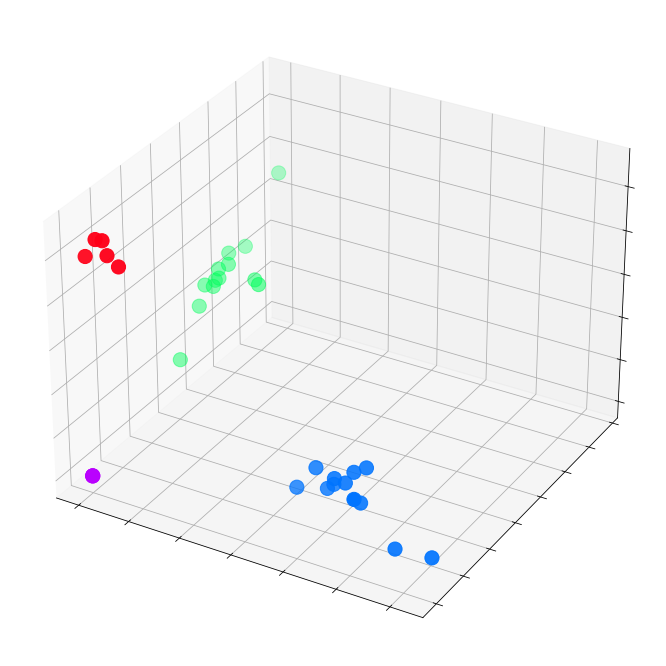

In [64]:
# embeddings do not need to have the same dimenstions as feature vectors
# here, reduce the number of dimenstions from 34 to 3

embed = h.detach().cpu().numpy()

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.patch.set_alpha(0)
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
           s=200, c=data.y, cmap="hsv", vmin=-2, vmax=3)

plt.show()

In [ ]:
# can see GCN learned embeddings that group nodes from the same classes into nice clusters

# Embeddings are not unique to GNNS
# can be found everywhere in deep learning
# additional dimensions store more information about nodes, text, images, etc
# but they also create bigger models that are more difficult to train
# this is why it's better to keep low-dimensional embeddings as long as potssible